# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).


Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Импорт и первичный просмотр данных:

In [ ]:
import datetime
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)

### Обзор данных:

In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [ ]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5695,1813-JYWTO,2014-02-01,No,Two year,No,Bank transfer (automatic),80.45,5737.6
2339,4094-NSEDU,2018-04-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,94.25,1973.75
420,2233-FAGXV,2019-09-01,No,Month-to-month,Yes,Mailed check,24.30,132.25
6976,5130-YPIRV,2014-12-01,No,Two year,Yes,Credit card (automatic),72.00,4284.2
4418,0378-XSZPU,2015-03-01,2020-01-01 00:00:00,One year,No,Credit card (automatic),60.30,3563.8


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [ ]:
contract.duplicated().sum()

0

#### Мини вывод по датафрейму contract:

Просмотрели немного данных. Пропусков нет. Дубликатов нет. 

Изменить:
- Тип данных столбцов даты начала и конца действия договора;
- Тип данных столбца суммарный платеж.

In [ ]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [ ]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1985,5373-SFODM,Fiber optic,No,No,No,No,No,Yes
2232,1897-OKVMW,DSL,Yes,Yes,Yes,Yes,Yes,Yes
5031,6302-JGYRJ,DSL,No,Yes,No,Yes,Yes,Yes
2896,7346-MEDWM,Fiber optic,No,Yes,Yes,No,No,No
306,6158-HDPXZ,DSL,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [ ]:
internet.duplicated().sum()

0

#### Мини вывод по датафрейму internet:

Просмотрели немного данных. Пропусков нет. Дубликатов нет. 

In [ ]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [ ]:
phone.sample(5)

,customerID,MultipleLines
4326,3646-ITDGM,No
2678,5294-IMHHT,Yes
1924,7422-WNBTY,Yes
381,4360-PNRQB,Yes
1538,6839-ITVZJ,Yes


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [ ]:
phone.duplicated().sum()

0

#### Мини вывод по датафрейму phone:

Просмотрели немного данных. Пропусков нет. Дубликатов нет. 

In [ ]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [ ]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
2759,1194-SPVSP,Male,0,No,No
3018,4176-RELJR,Male,1,No,No
228,4811-JBUVU,Male,0,No,No
1246,9408-HRXRK,Female,0,Yes,Yes
424,8111-BKVDS,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [ ]:
personal.duplicated().sum()

0

#### Мини вывод по датафрейму personal:

Просмотрели немного данных. Пропусков нет. Дубликатов нет. 

### Общий вывод по всем датафреймам:

Пропусков и дубликатов не наблюдается. Предварительно можно рассуждать, что данных достаточно, для создания модели прогнозирования оттока клиентов.
 
Необходимо:
- изменить тип данных по столбцам, где это необходимо;  
- проанализировать данные на наличие аномалий и ошибок;    
- сгруппировать предоставленные таблицы  по пользователю и объединить в единую таблицу , выделить таргет.

## Подготовка данных:

In [ ]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Посмотрели столбец с датой окончанием договоров.Определим целевую переменную таким образом: по договорам , которые прекратили действие, где дата окончания не 'No', метка , что договор расторгнут - 1, все остальные договора метка, что договор действующий - 0 , т.е договор не расторгнут.

In [ ]:
contract['target'] = [1 if i != 'No' else 0 for i in contract['EndDate']]

<AxesSubplot:xlabel='target', ylabel='count'>

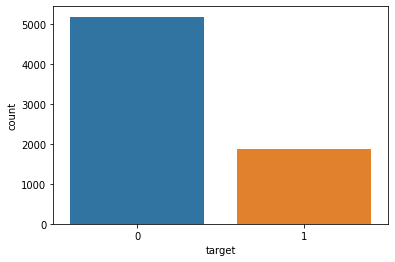

In [ ]:
sns.countplot(contract['target'])

Наблюдаем дисбаланс целевого признака

In [ ]:
contract.loc[(contract['EndDate'] == 'No'),'EndDate'] = '2020-02-01 00:00:00'

In [ ]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'],format= "%Y/%m/%d")
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'],format= "%Y/%m/%d")

Изменили тип данных и добавили целевую переменную.

In [ ]:
contract['TotalCharges'].value_counts().sort_index()

          11
100.2      1
100.25     1
100.35     1
100.4      1
          ..
997.75     1
998.1      1
999.45     1
999.8      1
999.9      1
Name: TotalCharges, Length: 6531, dtype: int64

In [ ]:
contract['TotalCharges'].value_counts().sort_index()

          11
100.2      1
100.25     1
100.35     1
100.4      1
          ..
997.75     1
998.1      1
999.45     1
999.8      1
999.9      1
Name: TotalCharges, Length: 6531, dtype: int64

Нашли 11 клиентов, у которых суммарнуй платеж отсутствует.

In [ ]:
contract.loc[contract['TotalCharges'] == " "]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0


Это клиенты, подписавышие договор 2020-02-01, т.е. это новички. Заполним пропуски нулями.

In [ ]:
contract.loc[(contract['TotalCharges'] == ' '), 'TotalCharges'] = '0.00'
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

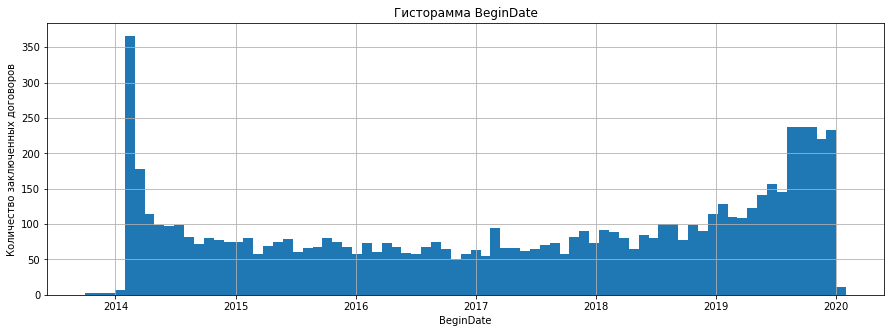

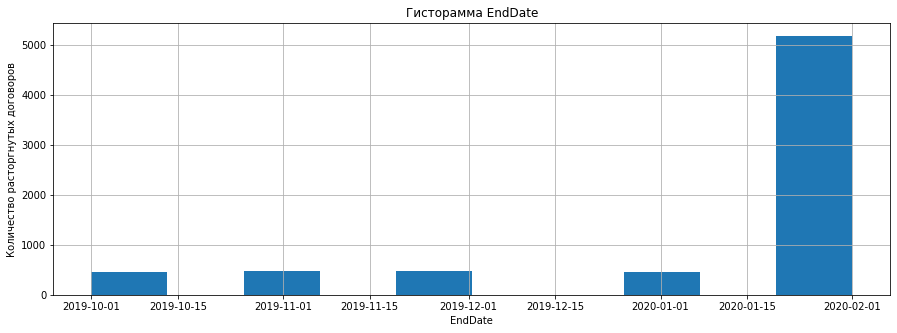

In [ ]:
plt.figure(figsize=(15,5))
contract['BeginDate'].hist(bins=77)
plt.ylabel('Количество заключенных договоров')
plt.xlabel('BeginDate')
plt.title('Гисторамма BeginDate')
plt.show()

plt.figure(figsize=(15,5))
contract['EndDate'].hist()
plt.ylabel('Количество расторгнутых договоров')
plt.xlabel('EndDate')
plt.title('Гисторамма EndDate')
plt.show()

Рассчитаем разницу между датой начала договора и датой окончания(только по договорам закрытым до 2020-02-01) в месяцах и построим гистограмму распределения и боксплот.

Text(0, 0.5, 'Частота')

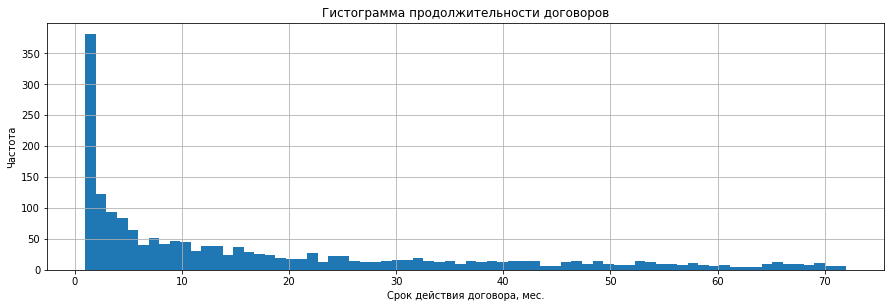

In [ ]:
df = contract.loc[contract['EndDate'] != "2020-02-01"]
df['period_contract'] = round((df['EndDate']-df['BeginDate']) / np.timedelta64(1,'M'),0)
plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
df['period_contract'].hist(bins=72)
plt.title(f'Гистограмма продолжительности договоров')
plt.xlabel(f'Срок действия договора, мес.')
plt.ylabel('Частота')

Нашли хороший синтетический признак - длительность контракта.

Распределение продолжительности договора экспоненциальное, что логично, договоров с коротким сроком больше, чем договоров с длинным сроком.

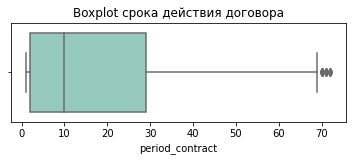

In [ ]:
plt.subplot(2, 1, 2)
sns.boxplot(df['period_contract'], orient="h", palette="Set3")
plt.title(f'Boxplot срока действия договора')      
plt.show()

Построим гистограммы по категориальным столбцам в разрезе таргета.

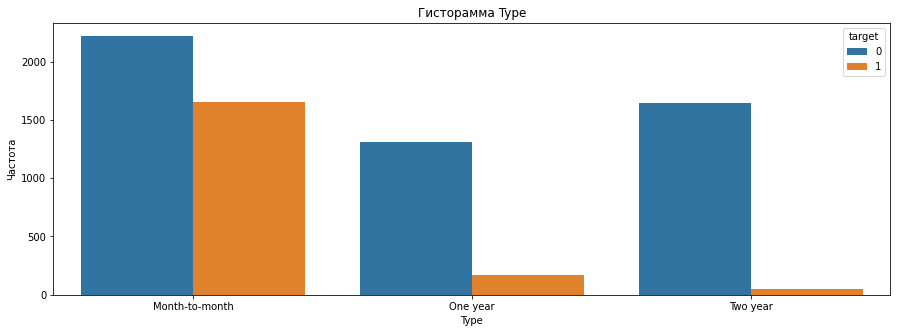

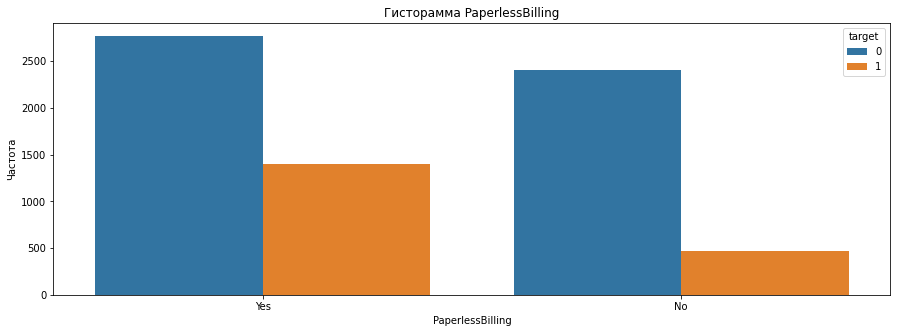

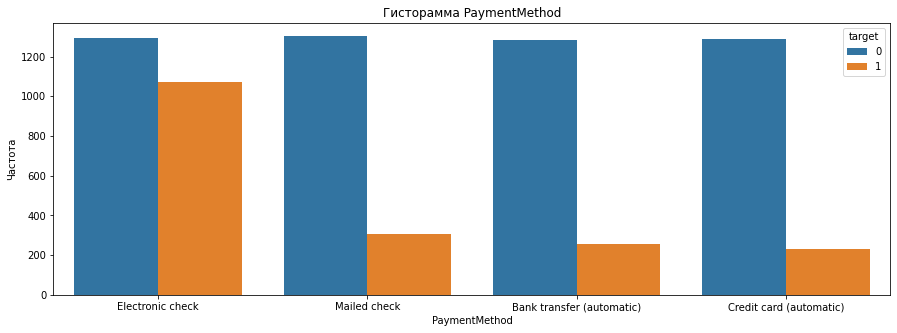

In [ ]:
for i in ['Type','PaperlessBilling','PaymentMethod']:
    plt.figure(figsize=(15,5))
    sns.countplot(data=contract,x=i,hue='target')
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Согласно графикам при Типе оплаты годом или двухлетнем вероятность ухода значительно ниже, чем при ежемесячном платеже, так же реже уходят клиенты, у которых наличный расчет оплаты.

Теперь проверим есть ли зависимость между таргетом и типом оплаты. Сделать это можно при помощи А/Б теста. Цель - определить есть ли зависимость между таргетом и типом оплаты. 

Нулевая гипотеза: Нет никакой связи между переменными.
Альтернативная гипотеза: между ними существует значительная связь .

In [ ]:
count_table = pd.crosstab(contract['target'],contract['Type']) 
(count_table) 
data = count_table
stat, p, dof, expected = chi2_contingency(data)
alpha = 0.05
display(f'p value is {str (p)}')
if p <= alpha:
    display('Нужно отвергнуть нулевую гипотезу' )
else :
    display('Нулевая гипотеза не может быть отвергнута')

'p value is 5.863038300673391e-258'

'Нужно отвергнуть нулевую гипотезу'

Мы добились нашей цели и узнали, что связь между таргетом и типом оплаты существует. 

Закодируем данные из столбцов некоторых столбцов в датафрейме contract и добавим в исходную таблицу.

In [ ]:
#contract = contract.join(pd.get_dummies(contract[['Type','PaperlessBilling','PaymentMethod']], drop_first=True))
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
3453,0326-VDYXE,2014-04-01,2020-02-01,One year,Yes,Electronic check,97.65,"6,982.50",0
4020,4334-HOWRP,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),64.95,"4,546.00",0
3469,9402-ORRAH,2018-11-01,2020-02-01,Month-to-month,Yes,Electronic check,91.50,"1,400.30",0
542,2866-IKBTM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,0
6054,9445-SZLCH,2016-12-01,2019-12-01,Month-to-month,Yes,Bank transfer (automatic),97.35,"3,457.90",1


Добавим в датафрейм два новых столбца. Первый будет c периодом действия договора, если будут незакрытые года, будем использовать дату до которой предоставлены данные. Второй будет период проплаченный по договору.

In [ ]:
contract['period']=(contract['EndDate']-contract['BeginDate'])/np.timedelta64(1,'D')

In [ ]:
contract['period_payment']=(contract['TotalCharges']/contract['MonthlyCharges'])

Избавимся от некоторых бесполезных, как мне кажется, данных. При этом создадим новый датафрейм.

In [ ]:
contract_c = contract[['customerID',                      
                      'target',
                      'PaperlessBilling',
                      'PaymentMethod',
                      'MonthlyCharges',
                      'TotalCharges',
                      'period',
                      'period_payment',
                     ]]

In [ ]:
contract_c.sample(5)

,customerID,target,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,period,period_payment
1554,9313-QOLTZ,0,No,Mailed check,20.90,518.30,792.00,24.80
3684,2842-BCQGE,0,Yes,Credit card (automatic),75.35,"3,161.40","1,310.00",41.96
2759,1194-SPVSP,0,No,Bank transfer (automatic),19.65,19.65,31.00,1.00
3112,8809-XKHMD,0,Yes,Bank transfer (automatic),100.55,"7,325.10","2,191.00",72.85
2266,5732-IKGQH,0,Yes,Bank transfer (automatic),104.45,"5,481.25","1,584.00",52.48


Все успешно получилось. Перейдем к анализу другого датафрейма.

In [ ]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4655,7163-OCEQI,DSL,No,No,Yes,Yes,Yes,Yes
4912,4023-RTIQM,DSL,Yes,Yes,Yes,No,No,Yes
2970,1508-DFXCU,Fiber optic,No,No,No,No,Yes,No
3311,7629-WFGLW,Fiber optic,Yes,Yes,Yes,Yes,No,No
389,5168-MQQCA,Fiber optic,No,Yes,Yes,Yes,Yes,Yes


Проверим на дубликаты customerID, StreamingTV и StreamingMovies, а после, как делали это ранее построим гистограммы по категориальным признакам.

In [ ]:
internet.loc[internet['customerID'].duplicated()]

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


In [ ]:
internet['customerID'].value_counts().sort_values()

2798-NYLMZ    1
1266-NZYUI    1
1724-BQUHA    1
2103-ZRXFN    1
0270-THENM    1
             ..
2155-AMQRX    1
7746-QYVCO    1
4446-BZKHU    1
0823-HSCDJ    1
8922-LIEGH    1
Name: customerID, Length: 5517, dtype: int64

In [ ]:
(internet['StreamingTV']==internet['StreamingMovies']).value_counts()

True     3958
False    1559
dtype: int64

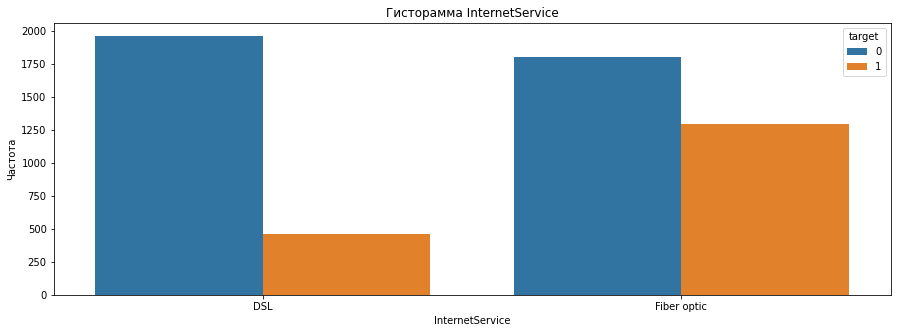

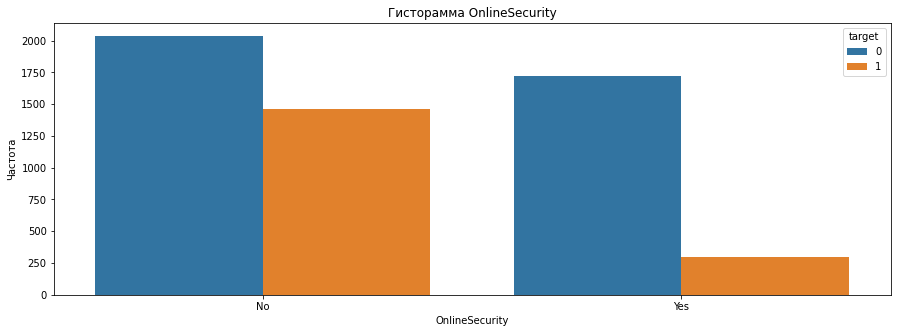

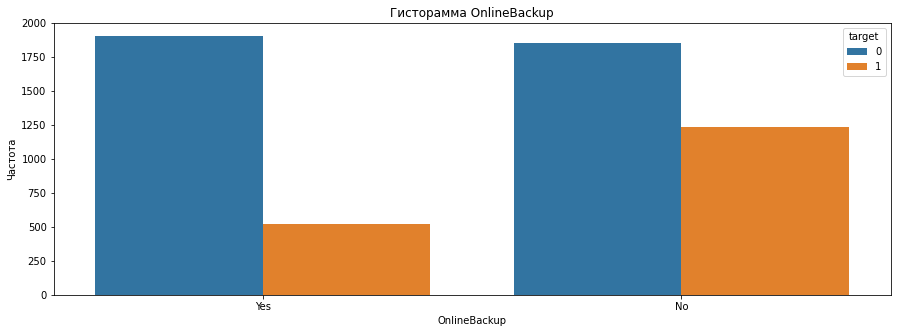

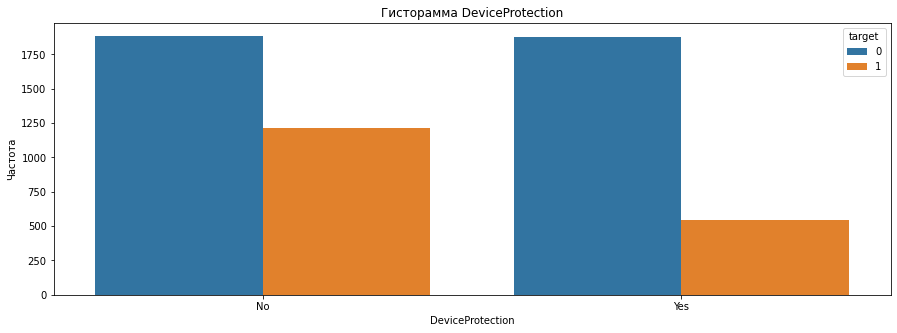

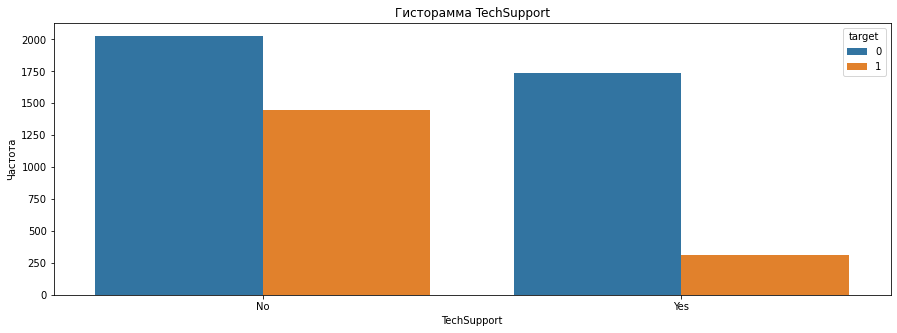

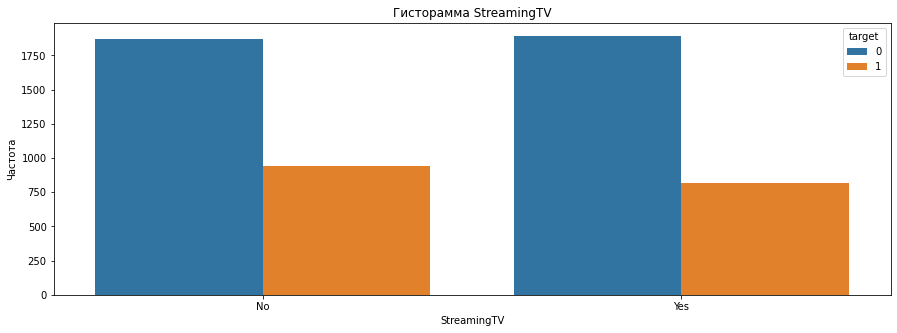

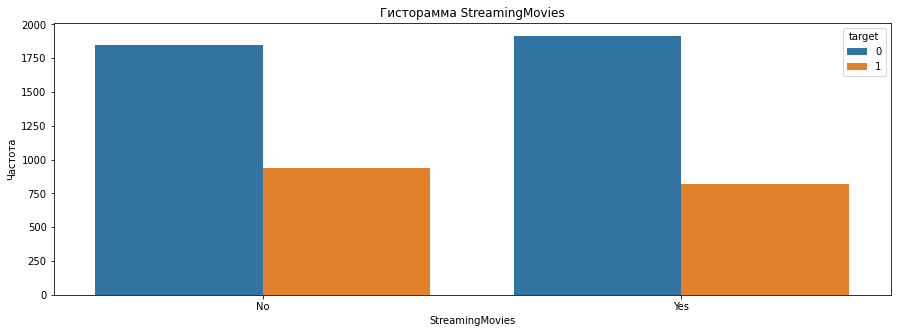

In [ ]:
for i in ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    plt.figure(figsize=(15,5))
    sns.countplot(data=contract.merge(internet,how='outer'),x=i,hue='target')
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Наблюдется зависимость таргета от данных признаков, наименьшая зависимость от StreamingMovies и StreamingTV

Сделаем то же самое с столбцами из датафрема internet, а именно закодируем их.

In [ ]:
#internet = internet.join(pd.get_dummies(internet[['InternetService',
#                                                  'OnlineSecurity',
#                                                 'OnlineBackup',
#                                                  'DeviceProtection',
#                                                  'TechSupport',
#                                                  'StreamingTV',
#                                                  'StreamingMovies']],
#                                        drop_first=True))
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet_c = internet[['customerID',
                    'InternetService',
                    'OnlineSecurity',
                    'OnlineBackup',
                    'DeviceProtection',
                    'TechSupport',
                    'StreamingTV',
                    'StreamingMovies']]

In [ ]:
#phone = phone.join(pd.get_dummies(phone[['MultipleLines']], drop_first=True))

In [ ]:
phone.sample(5)

,customerID,MultipleLines
2470,4749-VFKVB,Yes
2103,6670-MFRPK,Yes
1987,1178-PZGAB,No
5176,3785-NRHYR,No
4909,9715-SBVSU,No


In [ ]:
phone.duplicated().sum()

0

In [ ]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

Закодировали стобец MultipleLines. А также проверили датафрейм на дубликаты и пропуски, их нет.

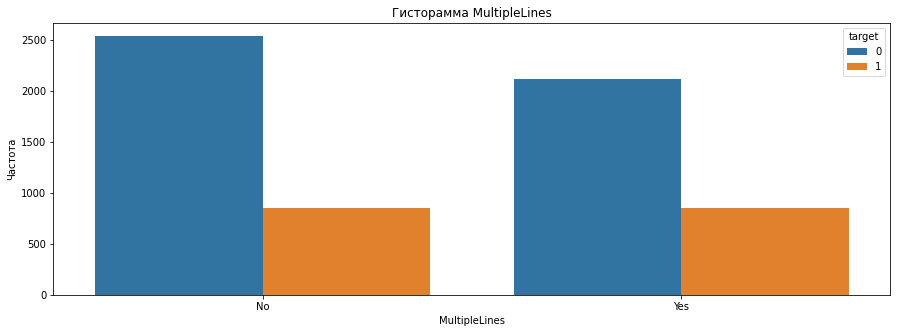

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=contract.merge(phone,how='outer'),x='MultipleLines',hue='target')
plt.ylabel('Частота')
plt.xlabel('MultipleLines')
plt.title(f'Гисторамма MultipleLines')
plt.show()

Из графика видно, что влияние multiplelines на target минимально. Перейдем к датафрейму personal.

In [ ]:
phone_c = phone[['customerID','MultipleLines']]

In [ ]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
2611,5976-JCJRH,Male,0,Yes,No
3422,1837-YQUCE,Female,0,No,No
4575,8746-OQQRW,Male,0,No,No
436,4980-URKXC,Male,0,Yes,No
5507,5753-QQWPW,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

In [ ]:
personal.duplicated().sum()

0

In [ ]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Дубликатов и пропусков нет. Изменили тип данных у столбца SeniorCitizen.

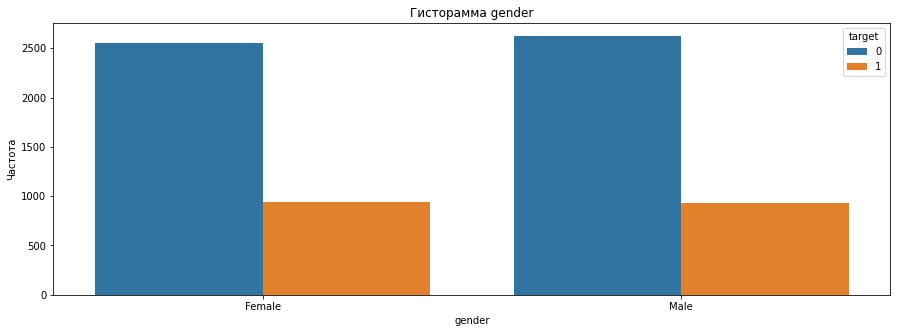

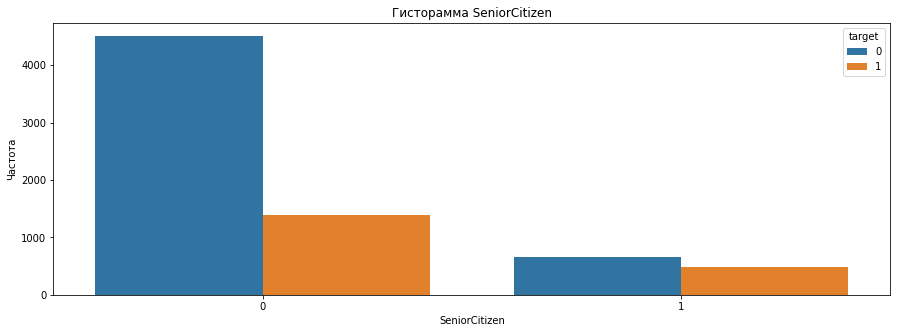

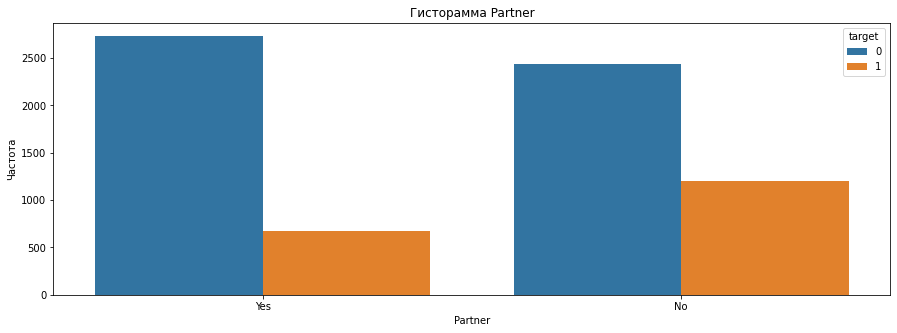

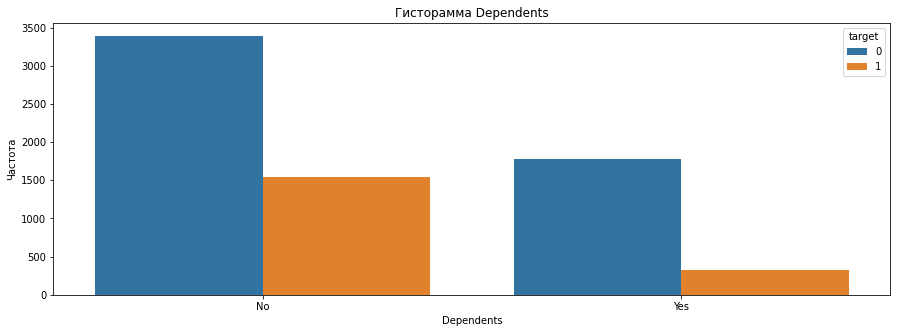

In [ ]:
for i in ['gender','SeniorCitizen','Partner','Dependents']:
    plt.figure(figsize=(15,5))
    sns.countplot(data=contract.merge(personal,how='outer'),x=i,hue='target')
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Из графиков понятно, что gender никак не влияет на target. Сначала закодируем столбцы, а потом перейдем к слиянию таблиц.

In [ ]:
#personal = personal.join(pd.get_dummies(personal[['gender','SeniorCitizen','Partner','Dependents']], drop_first=True))

In [ ]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
5791,7233-DRTRF,Male,0,Yes,No
5514,0623-GDISB,Female,0,No,No
375,7156-MXBJE,Female,0,No,No
3535,3612-YUNGG,Male,0,Yes,Yes
2604,6481-ESCNL,Female,0,No,No


In [ ]:
personal_c = personal[['customerID',
                    'gender',
                    'SeniorCitizen',
                    'Partner',
                    'Dependents'
                   ]]

### Слияние таблиц

In [ ]:
dFrames = [contract_c, internet_c, personal_c, phone_c]
df_c = reduce(lambda  left,right: pd.merge(left,right,on=['customerID'], how='outer'), dFrames)

In [ ]:
df_c.sample(5)

,customerID,target,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,period,period_payment,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
5442,2481-SBOYW,0,Yes,Credit card (automatic),25.00,"1,498.35","1,857.00",59.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,Yes,Yes
5699,6719-OXYBR,0,No,Electronic check,85.30,"1,219.85",457.00,14.30,Fiber optic,No,No,Yes,No,Yes,No,Male,0,No,No,No
5444,1833-TCXKK,0,Yes,Bank transfer (automatic),107.75,"4,882.80","1,371.00",45.32,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,0,Yes,No,Yes
743,4018-PPNDW,0,Yes,Mailed check,24.10,"1,551.60","1,857.00",64.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,Yes
526,8606-CIQUL,0,Yes,Credit card (automatic),115.75,"8,399.15","2,191.00",72.56,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,1,Yes,Yes,Yes


In [ ]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   target            7043 non-null   int64  
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   period            7043 non-null   float64
 7   period_payment    7043 non-null   float64
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   object 


In [ ]:
df_c.duplicated().sum()

0

In [ ]:
df_c.isna().sum()

customerID             0
target                 0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
period                 0
period_payment         0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Увидели пропуски. Скорее всего, если в строке пропуск, то клиенту не предоставлялась эта услуга. Поэтому вместо пропусков поставим 0.

In [ ]:
df_c.fillna(0,inplace=True)

Теперь посмотрим посмотрим корреляцию факторов.

In [ ]:
f_num =  ['MonthlyCharges','period', 'period_payment','TotalCharges']
df_c.loc[:, f_num].corr().style.applymap(lambda x: f"color: {'green' if (abs(x) > 0.5  and x !=1) else 'black'}")

,MonthlyCharges,period,period_payment,TotalCharges
MonthlyCharges,1.000000,0.247754,0.247539,0.651174
period,0.247754,1.000000,0.998934,0.826109
period_payment,0.247539,0.998934,1.000000,0.826458
TotalCharges,0.651174,0.826109,0.826458,1.000000


Можно заметить высокую корреляцию между TotalCharges и всеми другими признаками, поэтому данный столбец не будем включать в итоговый список. Также высокая корреляция между периодом действия договора и периодом проплаченным по договору, оставим для модели только период действия договора.

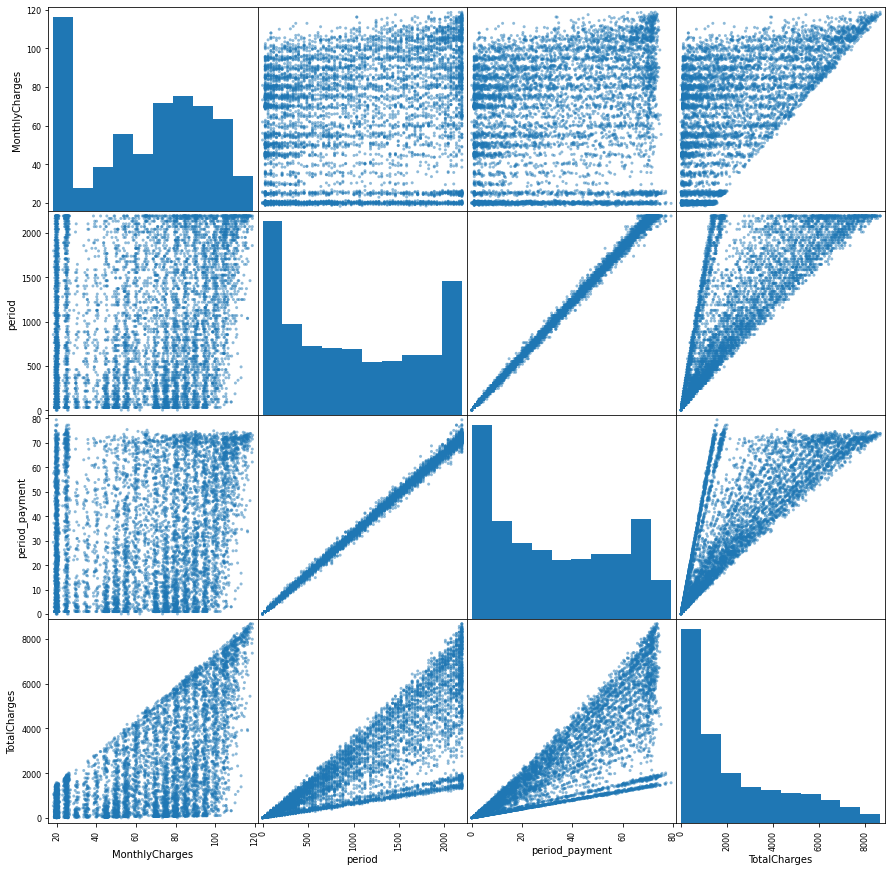

In [ ]:
pd.plotting.scatter_matrix(df_c.loc[:,f_num],figsize=(15,15))
plt.show()

Для формирования фичей оставим все категориальные признаки и из количественных признаков оставим только период действия договора и ежесячный платеж.

## Построение модели

In [ ]:
def no_to_zero_yes_to_one(data, columns_given):
    for column in columns_given:
        data.loc[data[column] == 'No', column] = 0
        data.loc[data[column] == 'Yes', column] = 1

In [ ]:
needed_to_change = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "Partner", "Dependents", "MultipleLines",
                    "TechSupport","StreamingTV","StreamingMovies"]

In [ ]:
no_to_zero_yes_to_one(df_c, needed_to_change)

In [ ]:
df_c.sample(5)

,customerID,target,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,period,period_payment,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
1969,5110-CHOPY,0,No,Electronic check,53.60,"3,237.05","1,826.00",60.39,DSL,1,0,1,0,1,1,Female,0,0,0,0
6108,4819-HJPIW,0,No,Mailed check,25.15,476.80,549.00,18.96,DSL,0,0,0,0,0,0,Male,0,0,0,0
1220,0872-JCPIB,0,No,Bank transfer (automatic),65.75,"1,111.20",518.00,16.90,DSL,1,0,0,0,0,1,Male,0,0,0,1
4692,0265-PSUAE,0,No,Bank transfer (automatic),100.70,"1,522.70",488.00,15.12,Fiber optic,1,0,1,0,1,1,Female,0,1,1,0
2024,8272-ONJLV,0,No,Electronic check,95.70,"1,184.00",365.00,12.37,Fiber optic,0,0,1,0,1,1,Male,0,0,0,0


In [ ]:
del df_c['customerID']

In [ ]:
encoder = OrdinalEncoder()
df_c[[
    "PaperlessBilling", "PaymentMethod", "gender"]] = (
    
    encoder.fit_transform(df_c[[
    "PaperlessBilling", "PaymentMethod", "gender"]]))

In [ ]:
df_c = pd.get_dummies(df_c, drop_first=True)

In [ ]:
df_train, df_test = train_test_split(df_c, test_size=0.2, random_state=311022)

In [ ]:
features_train = df_train.drop(columns = ['target'])
target_train = df_train['target']
features_test = df_test.drop(columns = ['target'])
target_test = df_test['target']

In [ ]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5634, 19), (1409, 19), (5634,), (1409,))

In [ ]:
#tr_features.shape, val_features.shape, tr_target.shape, val_target.shape

### Обучение

In [ ]:
parameters = {
    'rf__n_estimators' : [25,50,100,150],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__max_depth':[5,10,20],
}         
steps = [('standard_scaler', StandardScaler()),
         ('rf', RandomForestClassifier(random_state=311022))
        ]
pipe = Pipeline(steps)
cls_rf = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
cls_rf.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=311022))]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [5, 10, 20],
                         'rf__n_estimators': [25, 50, 100, 150]},
             scoring='roc_auc')

In [ ]:
cls_rf.best_params_

{'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__n_estimators': 150}

In [ ]:
scores_rf = cls_rf.score(features_test, target_test)
scores_rf

0.8523991102637432

In [ ]:
%%time
CB_model = CatBoostClassifier()
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [5, 7, 9],
        'iterations': [10, 100, 1000]}

#grid = {'learning_rate': [0.03, 0.1],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

CV_model = GridSearchCV(estimator=CB_model, param_grid=grid, cv= 5)

CV_model.fit(features_train, target_train)
print(CV_model.best_params_)

0:	learn: 0.6811828	total: 47.3ms	remaining: 426ms
1:	learn: 0.6703073	total: 48.9ms	remaining: 196ms
2:	learn: 0.6600862	total: 50ms	remaining: 117ms
3:	learn: 0.6503458	total: 51ms	remaining: 76.6ms
4:	learn: 0.6417203	total: 51.9ms	remaining: 51.9ms
5:	learn: 0.6328433	total: 52.8ms	remaining: 35.2ms
6:	learn: 0.6248875	total: 53.7ms	remaining: 23ms
7:	learn: 0.6169190	total: 54.7ms	remaining: 13.7ms
8:	learn: 0.6096460	total: 55.8ms	remaining: 6.2ms
9:	learn: 0.6026551	total: 56.8ms	remaining: 0us
0:	learn: 0.6809373	total: 1.58ms	remaining: 14.2ms
1:	learn: 0.6701172	total: 3.33ms	remaining: 13.3ms
2:	learn: 0.6597087	total: 4.77ms	remaining: 11.1ms
3:	learn: 0.6497849	total: 6.25ms	remaining: 9.38ms
4:	learn: 0.6410023	total: 7.81ms	remaining: 7.81ms
5:	learn: 0.6323380	total: 9.29ms	remaining: 6.2ms
6:	learn: 0.6242124	total: 10.6ms	remaining: 4.53ms
7:	learn: 0.6162428	total: 12ms	remaining: 2.99ms
8:	learn: 0.6085097	total: 13.4ms	remaining: 1.49ms
9:	learn: 0.6015208	total: 1

KeyboardInterrupt: 

Модель очень долго обучается.

Запустил сразу на известных гиперпараметрах.

In [ ]:
%%time
CB_model = CatBoostClassifier(iterations=1000, depth=10, l2_leaf_reg=9, learning_rate=0.1, random_state=311022)
CB_model.fit(features_train, target_train)
CB_model_prediction = CB_model.predict_proba(features_test)

0:	learn: 0.6287159	total: 18.2ms	remaining: 18.1s
1:	learn: 0.5820555	total: 35.7ms	remaining: 17.8s
2:	learn: 0.5433166	total: 57.6ms	remaining: 19.1s
3:	learn: 0.5141764	total: 76.4ms	remaining: 19s
4:	learn: 0.4905606	total: 95ms	remaining: 18.9s
5:	learn: 0.4706228	total: 112ms	remaining: 18.5s
6:	learn: 0.4557257	total: 130ms	remaining: 18.5s
7:	learn: 0.4436299	total: 135ms	remaining: 16.8s
8:	learn: 0.4333860	total: 145ms	remaining: 15.9s
9:	learn: 0.4231423	total: 162ms	remaining: 16s
10:	learn: 0.4149219	total: 179ms	remaining: 16.1s
11:	learn: 0.4105662	total: 182ms	remaining: 15s
12:	learn: 0.4039360	total: 200ms	remaining: 15.2s
13:	learn: 0.3981404	total: 218ms	remaining: 15.4s
14:	learn: 0.3917798	total: 236ms	remaining: 15.5s
15:	learn: 0.3900792	total: 238ms	remaining: 14.6s
16:	learn: 0.3853787	total: 255ms	remaining: 14.7s
17:	learn: 0.3816803	total: 276ms	remaining: 15.1s
18:	learn: 0.3781855	total: 297ms	remaining: 15.3s
19:	learn: 0.3759949	total: 316ms	remaining:

In [ ]:
scores_cb = CB_model.score(features_test, target_test)
scores_cb

0.8530872959545777

In [ ]:
parameters = {
    'gbr__learning_rate' : [0.1,],
    'gbr__n_estimators' : [100,],
    'gbr__max_depth':[3,],
    'gbr__min_samples_split': [2,],
    'gbr__min_samples_leaf': [2,]  
}
steps = [
    ('standard_scaler', StandardScaler()),
    ('gbr', GradientBoostingClassifier(random_state=311022))
]
pipe = Pipeline(steps)

cls_gbr = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cls_gbr.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('gbr',
                                        GradientBoostingClassifier(random_state=311022))]),
             param_grid={'gbr__learning_rate': [0.1], 'gbr__max_depth': [3],
                         'gbr__min_samples_leaf': [2],
                         'gbr__min_samples_split': [2],
                         'gbr__n_estimators': [100]},
             scoring='roc_auc')

In [ ]:
cls_gbr.best_params_

{'gbr__learning_rate': 0.1,
 'gbr__max_depth': 3,
 'gbr__min_samples_leaf': 2,
 'gbr__min_samples_split': 2,
 'gbr__n_estimators': 100}

In [ ]:
scores_gbr = cls_gbr.score(features_test, target_test)
scores_gbr

0.8801543798326448

Значения score выше у GradientBoosting модели, так что берем ее.

In [ ]:
df_c.head()

,target,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,period,period_payment,gender,SeniorCitizen,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_1,OnlineBackup_1,DeviceProtection_1,TechSupport_1,StreamingTV_1,StreamingMovies_1,Partner_1,Dependents_1,MultipleLines_1
0,0,1.00,2.00,29.85,29.85,31.00,1.00,0.00,0,1,0,0,1,0,0,0,0,1,0,0
1,0,0.00,3.00,56.95,"1,889.50","1,036.00",33.18,1.00,0,1,0,1,0,1,0,0,0,0,0,0
2,1,1.00,3.00,53.85,108.15,61.00,2.01,1.00,0,1,0,1,1,0,0,0,0,0,0,0
3,0,0.00,0.00,42.30,"1,840.75","1,371.00",43.52,1.00,0,1,0,1,0,1,1,0,0,0,0,0
4,1,1.00,2.00,70.70,151.65,61.00,2.14,0.00,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
features = ['PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'period', 'period_payment', 'gender', 'SeniorCitizen',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_1', 'OnlineBackup_1', 'DeviceProtection_1',
       'TechSupport_1', 'StreamingTV_1', 'StreamingMovies_1', 'Partner_1',
       'Dependents_1', 'MultipleLines_1']

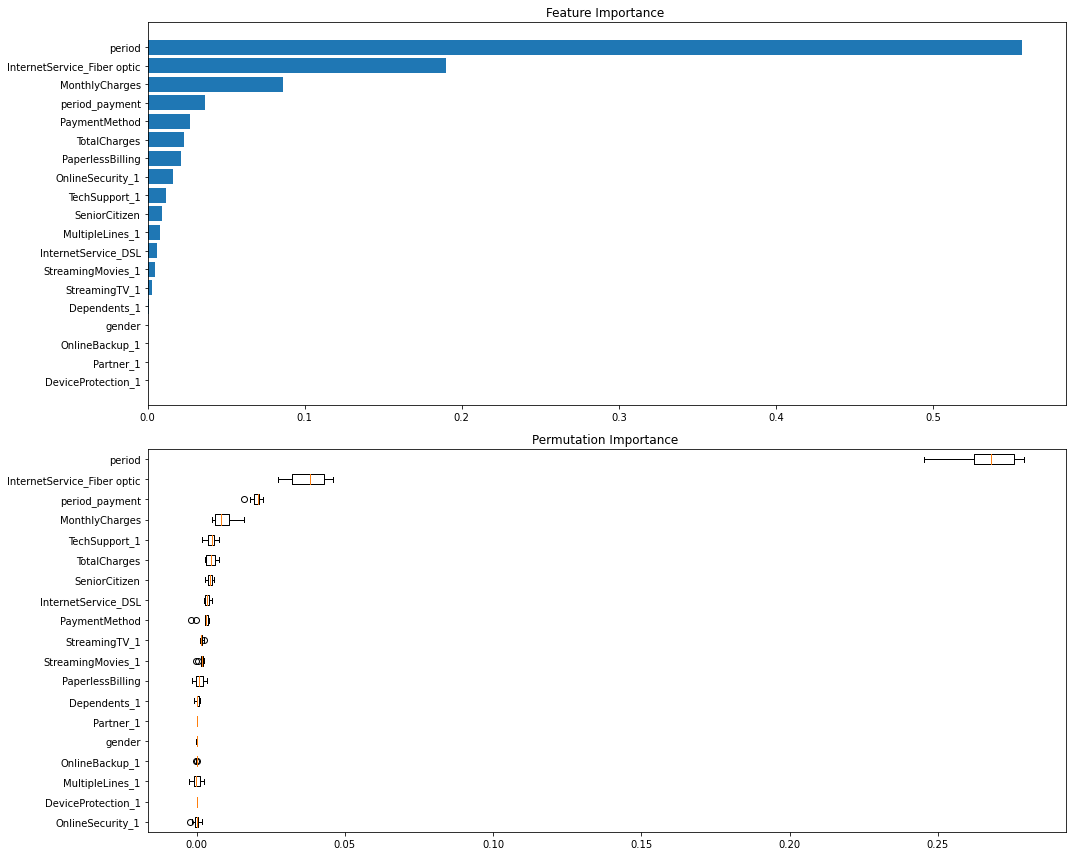

In [ ]:
feature_importance = cls_gbr.best_estimator_.fit(features_train, target_train).steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance ")

result = permutation_importance(
    cls_gbr, features_test, target_test, n_repeats=10, random_state=311022, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(2, 1, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features)[sorted_idx],
)
plt.title("Permutation Importance ")
fig.tight_layout()
plt.show()

Согласно графикам можно выделить несколько наиболее важнейших признаков. Наиболее важным является признак period, но это очевидно. Менее очевидным вариантом, но также сильно влияющим является признак InternetService_Fiber_optic. Также, довольно сильно, относительно других влияет MonthlyCharges. Остальные признаки влияют, но не так сильно, как первые три.

### Метрика

In [ ]:
display(f'Значение ROC_AUC: {roc_auc_score(target_test,CB_model_prediction[:,1])}')
display(f'Значение Accuracy: {accuracy_score(target_test,CB_model_prediction[:,1])}')

In [ ]:
res=pd.DataFrame(columns=['name_model',
                          'roc_auc',
                          'accuracy',
                          'f1_score',                          
                          'precision',
                          'recall',
                          'num features'                          
                         ],
                 data=[['GradientBoosting c GridSearch все параметры',
                       roc_auc_score(target_test,cls_gbr.predict_proba(features_test)[:, 1]),
                       accuracy_score(target_test,cls_gbr.predict(features_test)),
                       f1_score(target_test,cls_gbr.predict(features_test)),
                       precision_score(target_test,cls_gbr.predict(features_test)),
                       recall_score(target_test,cls_gbr.predict(features_test)),
                       features_test.shape[1]
                      ]]
                )
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,GradientBoosting c GridSearch все параметры,0.88,0.83,0.63,0.74,0.54,19


## Вывод

Для прогнозирования оттока клиентов использовался дополнительный параметр период действия договора (Дата расторжения договора или дата на которую формируется выгрузка за вычетом Даты подписания договора). Целевая переменная определялась по столбцу EndDate.

Лучший результат roc-auc 0,88.